<a href="https://colab.research.google.com/github/lamd91/VAE_DA/blob/master/VAE_MPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import math
import random
from IPython import display
import os
import shutil

In [93]:
# Mount Google Drive at "/content/gdrive"
from google.colab import drive
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [100]:
# After you have uploaded "mps_simulations.tar.gz" on Google Drive, extract the 
# folder here in Colab
!tar -xf "/content/gdrive/My Drive/mps_simulations.tar.gz" 
!rm -r images/.ipynb_checkpoints

(50, 500)


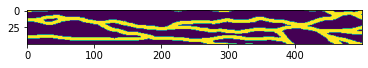

In [69]:
# Show one random MPS image
i = random.randint(0, 1999)
image = pickle.load(open(f'images/img-{i}.pickle', 'rb'))
plt.imshow(image)

In [105]:
# Define global constants
BATCH_SIZE = 32
LATENT_DIM = 2
EPOCHS = 1000
IMAGE_HEIGHT = 50
IMAGE_WIDTH = 500
NUM_CHANNELS = 1
TEST_SIZE = 0.2

In [117]:
def split_image_data_in_separate_dirs():
    data_dir_name = 'images'
    training_data_dir_name = 'training_data'
    testing_data_dir_name = 'testing_data'
    image_filenames = os.listdir(data_dir_name)
    num_examples = len(image_filenames)
    if not os.path.exists(training_data_dir_name):
        os.mkdir(training_data_dir_name)
    if not os.path.exists(testing_data_dir_name):
        os.mkdir(testing_data_dir_name)

    for file in image_filenames[0:int(num_examples*(1-TEST_SIZE))]:
        shutil.copy(os.path.join(data_dir_name, file), training_data_dir_name)

    for file in image_filenames[int(num_examples*(1-TEST_SIZE)):]:
        shutil.copy(os.path.join(data_dir_name, file), testing_data_dir_name)

    print("Num of training examples:", len(os.listdir(training_data_dir_name)))
    print("Num of testing examples:", len(os.listdir(testing_data_dir_name)))

split_image_data_in_separate_dirs()

Num of training examples: 1600
Num of testing examples: 400


In [ ]:
def map_image(image):
    '''Returns a reshaped tensor from a given image as input and as label'''
    image = tf.cast(image, dtype=tf.float32)
    image = tf.reshape(image, shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS,))

    return image, image

def augment_image(image):
    '''Returns as input and as label a reshaped tensor from a given image 
    which may have undergone some horizontal or vertical flipping '''
    image = tf.cast(image, dtype=tf.float32)
    image = tf.reshape(image, shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS,))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    return image, image

# def get_datasets(test_size):
#     """Loads and prepares the dataset from a text file."""
#     dataset = np.transpose(
#         np.loadtxt('/content/gdrive/My Drive/iniMPSimEns_1000.txt'))
#     num_examples = dataset.shape[0]
#     original_train_dataset = tf.data.Dataset.from_tensor_slices(
#         dataset[0:int(num_examples*(1-test_size))])
#     val_dataset = tf.data.Dataset.from_tensor_slices(
#         dataset[int(num_examples*(1-test_size)):])

#     augmented_train_dataset = original_train_dataset.map(augment_image).cache().shuffle(1024).batch(BATCH_SIZE)
#     original_train_dataset = original_train_dataset.map(map_image).cache().shuffle(1024).batch(BATCH_SIZE)
#     val_dataset = val_dataset.map(map_image).cache().batch(BATCH_SIZE)

#     return augmented_train_dataset, original_train_dataset, val_dataset, num_examples

def get_datasets(test_size):
    """Loads and prepares the dataset from a 2D array loaded from a text file."""
    dataset = np.transpose(
        np.loadtxt('/content/gdrive/My Drive/iniMPSimEns_1000.txt'))
    num_examples = dataset.shape[0]
    original_train_dataset = tf.data.Dataset.from_tensor_slices(
        dataset[0:int(num_examples*(1-test_size))])
    val_dataset = tf.data.Dataset.from_tensor_slices(
        dataset[int(num_examples*(1-test_size)):])

    original_train_dataset = original_train_dataset.map(map_image).batch(int(num_examples*(1-test_size)))
    val_dataset = val_dataset.map(map_image).batch(int(num_examples*(1-test_size)))

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        width_shift_range = 0.15,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest'
    )
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

    for input_images, images in original_train_dataset:
        x_train, y_train = input_images, images
    for input_images, images in val_dataset:
        x_val, y_val = input_images, images

    train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
    val_generator = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE)

    return train_generator, original_train_dataset, val_generator, num_examples

def display_three_train_images(train_dataset):
    """Displays 3 images from the training dataset"""
    plt.figure(figsize=(5, 14))
    for input_images, _ in train_dataset.take(1):
        for i in range(3):
            plt.subplot(3, 1, i+1)
            plt.imshow(np.squeeze(input_images[i]), cmap='gray')
    plt.show()

In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        """Generates a random sample and combines with the encoder output

        Args:
          inputs -- output tensor from the encoder

        Returns:
          `inputs` tensors combined with a random sample
        """

        # unpack the output of the encoder
        mu, sigma = inputs

        # get the size and dimensions of the batch
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]

        # generate a random tensor
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        # combine the inputs and noise
        return mu + tf.exp(0.5 * sigma) * epsilon


def encoder_layers(inputs, latent_dim):
    """Defines the encoder's layers.
    Args:
      inputs -- batch from the dataset
      latent_dim -- dimensionality of the latent space

    Returns:
      mu -- learned mean
      sigma -- learned standard deviation
      batch_2.shape -- shape of the features before flattening
    """

    # add the Conv2D layers followed by BatchNormalization
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, 
                               padding="same", activation='relu',
                               name="encode_conv1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, 
                               padding='same', activation='relu',
                               name="encode_conv2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, 
                               padding='same', activation='relu',
                               name="encode_conv3")(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, 
    #                            padding='same', activation='relu',
    #                            name="encode_conv4")(x)    

    # assign to a different variable so you can extract the shape later
    batch_3 = tf.keras.layers.BatchNormalization()(x)

    # flatten the features and feed into the Dense network
    x = tf.keras.layers.Flatten(name="encode_flatten")(batch_3)

    # we arbitrarily used ... units here but feel free to change
    x = tf.keras.layers.Dense(1024, activation='relu', name="encode_dense")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # add output Dense networks for mu and sigma, units equal to the declared latent_dim.
    mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
    sigma = tf.keras.layers.Dense(latent_dim, name='latent_sigma')(x)

    return mu, sigma, batch_3.shape

def encoder_model(latent_dim, input_shape):
    """Defines the encoder model with the Sampling layer
    Args:
      latent_dim -- dimensionality of the latent space
      input_shape -- shape of the dataset batch

    Returns:
      model -- the encoder model
      conv_shape -- shape of the features before flattening
    """

    # declare the inputs tensor with the given shape
    inputs = tf.keras.layers.Input(shape=input_shape)

    # get the output of the encoder_layers() function
    mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=LATENT_DIM)

    # feed mu and sigma to the Sampling layer
    z = Sampling()((mu, sigma))

    # build the whole encoder model
    model = tf.keras.Model(inputs, outputs=[mu, sigma, z])

    return model, conv_shape


# Define decision variables for adding Cropping2D layers in decoder layers

# topcrop_after_upsampling0 = (math.ceil(math.ceil(math.ceil(IMAGE_HEIGHT/2)/2)/2) % 2 != 0)
# leftcrop_after_upsampling0 = (math.ceil(math.ceil(math.ceil(IMAGE_WIDTH/2)/2)/2) % 2 != 0)
topcrop_after_upsampling1 = (math.ceil(math.ceil(IMAGE_HEIGHT/2)/2) % 2 != 0)
leftcrop_after_upsampling1 = (math.ceil(math.ceil(IMAGE_WIDTH/2)/2) % 2 != 0)
topcrop_after_upsampling2 = (math.ceil(IMAGE_HEIGHT/2) % 2 != 0)
leftcrop_after_upsampling2 = (math.ceil(IMAGE_WIDTH/2) % 2 != 0)
topcrop_after_upsampling3 = (IMAGE_HEIGHT % 2 != 0)
leftcrop_after_upsampling3 = (IMAGE_WIDTH % 2 != 0)


def decoder_layers(inputs, conv_shape, topcrop_after_upsampling1, 
                   leftcrop_after_upsampling1, topcrop_after_upsampling2, 
                   leftcrop_after_upsampling2,
                   topcrop_after_upsampling3, leftcrop_after_upsampling3):
    """Defines the decoder layers.
    Args:
      inputs -- output of the encoder
      conv_shape -- shape of the features before flattening

    Returns:
      tensor containing the decoded output
    """

    # feed to a Dense network with units computed from the conv_shape dimensions
    units = conv_shape[1] * conv_shape[2] * conv_shape[3]
    x = tf.keras.layers.Dense(units, activation='relu', name="decode_dense1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)

    # reshape output using the conv_shape dimensions
    x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), 
                                name="decode_reshape")(x)

    # upsample the features back to the original dimensions
    # for that, make sure to add Cropping2D layers after upsampling when needed
    # x = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, 
    #                                     padding='same', activation='relu',
    #                                     name="decode_conv2d_0")(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # if topcrop_after_upsampling0:
    #     x = tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0)))(x)
    # if leftcrop_after_upsampling0:
    #     x = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))(x)    
    x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, 
                                        padding='same', activation='relu',
                                        name="decode_conv2d_1")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if topcrop_after_upsampling1:
        x = tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0)))(x)
    if leftcrop_after_upsampling1:
        x = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                        padding='same', activation='relu',
                                        name="decode_conv2d_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if topcrop_after_upsampling2:
        x = tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0)))(x)
    if leftcrop_after_upsampling2:
        x = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                        padding='same', activation='relu',
                                        name="decode_conv2d_3")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if topcrop_after_upsampling3:
        x = tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0)))(x)
    if leftcrop_after_upsampling3:
        x = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                        padding='same', activation='sigmoid',
                                        name="decode_final")(x)

    return x

def decoder_model(latent_dim, conv_shape):
    """Defines the decoder model.
    Args:
      latent_dim -- dimensionality of the latent space
      conv_shape -- shape of the features before flattening

    Returns:
      model -- the decoder model
    """

    # set the inputs to the shape of the latent space
    inputs = tf.keras.layers.Input(shape=(latent_dim,))

    # get the output of the decoder layers
    outputs = decoder_layers(inputs, conv_shape, topcrop_after_upsampling1, 
                             leftcrop_after_upsampling1, 
                             topcrop_after_upsampling2, 
                             leftcrop_after_upsampling2, 
                             topcrop_after_upsampling3, 
                             leftcrop_after_upsampling3)

    # declare the inputs and outputs of the model
    model = tf.keras.Model(inputs, outputs)

    return model

def kl_reconstruction_loss(inputs, outputs, mu, sigma):
    """ Computes the Kullback-Leibler Divergence (KLD)
    Args:
      inputs -- batch from the dataset
      outputs -- output of the Sampling layer
      mu -- mean
      sigma -- standard deviation

    Returns:
      KLD loss
    """
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    kl_loss = tf.reduce_mean(kl_loss) * -0.5

    return kl_loss

def vae_model(encoder, decoder, input_shape):
    """Defines the VAE model
    Args:
      encoder -- the encoder model
      decoder -- the decoder model
      input_shape -- shape of the dataset batch

    Returns:
      the complete VAE model
    """
    # set the inputs
    inputs = tf.keras.layers.Input(shape=input_shape)

    # get mu, sigma, and z from the encoder output
    mu, sigma, z = encoder(inputs)

    # get reconstructed output from the decoder
    reconstructed = decoder(z)

    # define the inputs and outputs of the VAE
    model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

    # add the KL loss
    loss = kl_reconstruction_loss(inputs, z, mu, sigma)
    model.add_loss(loss)

    return model

def get_models(input_shape, latent_dim):
    """Returns the encoder, decoder, and vae models"""
    encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
    decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
    vae = vae_model(encoder, decoder, input_shape=input_shape)
    return encoder, decoder, vae

In [ ]:
# Define a VAE class via model subclassing
loss_metrics = tf.keras.metrics.Mean()
val_loss_metrics = tf.keras.metrics.Mean()

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, variational_autoencoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.vae = variational_autoencoder

    # override train_step method
    def train_step(self, images):
        if isinstance(images, tuple):
            images = images[0]
        with tf.GradientTape() as tape:
            # feed a batch to the VAE model
            reconstructed = self.vae(images)
            # compute reconstruction loss
            flattened_inputs = tf.reshape(images, [-1])
            flattened_outputs = tf.reshape(reconstructed, [-1])
            loss = self.compiled_loss(flattened_inputs, flattened_outputs) \
                   * images.shape[1] * images.shape[2]
            # add KLD regularization loss
            loss += sum(self.vae.losses)

        # compute the gradients and update the model weights
        grads = tape.gradient(loss, self.vae.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.vae.trainable_weights))

        # update metrics
        loss_metrics.update_state(loss)
        
        # return a dict mapping metrics names to current value
        return {'loss': loss_metrics.result()}

    # override test_step method
    def test_step(self, images):
        if isinstance(images, tuple):
            images = images[0]
        # compute predictions
        reconstructed = self.vae(images)
        # compute loss
        flattened_inputs = tf.reshape(images, [-1])
        flattened_outputs = tf.reshape(reconstructed, [-1])
        loss = self.compiled_loss(flattened_inputs, flattened_outputs) \
               * images.shape[1] * images.shape[2]
        # add KLD regularization loss
        loss += sum(self.vae.losses)
        # update metrics
        val_loss_metrics.update_state(loss)
        # return a dict mapping metrics names to current value
        return {'loss': val_loss_metrics.result()}

    def call(self, images):
        if isinstance(images, tuple):
            images = images[0]
        return self.vae(images)

In [ ]:
def generate_and_save_images(model, epoch, step, test_input, vae_model):
    """Helper function to plot our 8 images

    Args:

    model -- the decoder model
    epoch -- current epoch number during training
    step -- current step number during training
    test_input -- random tensor with shape (8, LATENT_DIM)
    """

    # generate images from the test input
    predictions = model.predict(test_input)

    # plot the results
    fig = plt.figure(figsize=(12, 14))

    for i in range(predictions.shape[0]):
        plt.subplot(8, 1, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    fig.suptitle("epoch: {}, step: {}".format(epoch, step))
    plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))

    if epoch != 0:
        fig = plt.figure()
        plt.scatter(range(len(vae_model.history.history['loss'])), vae_model.history.history['loss'])
        plt.scatter(range(len(vae_model.history.history['val_loss'])), vae_model.history.history['val_loss'], color='red')
        plt.savefig('Losses.png')
    plt.show()

def show_original_reconstructed_images(model, train_dataset):
    plt.figure(figsize=(10, 14))
    for input_images, _ in train_dataset:
        k = 0
        for i in range(5):
            reconstructed = model(np.expand_dims(input_images[i], axis=0))
            #reconstructed_categorized = np.where(reconstructed >= 0.5, 1, 0)
            plt.subplot(5, 2, k+1)
            plt.imshow(np.squeeze(input_images[i]), cmap='gray')
            plt.subplot(5, 2, k+2)
            #plt.imshow(np.squeeze(reconstructed_categorized), cmap='gray')
            plt.imshow(np.squeeze(reconstructed), cmap='gray')
            k += 2
        plt.savefig("reconstructed_images.png")
    plt.show()

Setting a learning rate scheduler for selecting the learning rate parameter during training

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Load and prepare image dataset for training
augmented_train_dataset, train_dataset, val_dataset, num_examples = get_datasets(test_size=TEST_SIZE)
print(f"Num of original examples: {num_examples}")
#display_three_train_images(train_dataset)

# Create a callback that saves the model's weights every few epochs during training
checkpoint_path = 'checkpoint/cp-cp{epoch:04d}.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    verbose = 1,
    save_weights_only = True,
    save_freq = math.ceil(num_examples/BATCH_SIZE) * 100
)

# Create custom callback to display outputs (via helper function) at the end of each epoch of training
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        # Generate random vector as test input to the decoder
        random_vector_for_generation = tf.random.normal(shape=[8, LATENT_DIM])
        # Generate and save images
        display.clear_output(wait=False)
        if epoch % 100 == 0:
            generate_and_save_images(decoder, epoch, 
                                     math.ceil(num_examples/BATCH_SIZE), 
                                     random_vector_for_generation, vae)
        print('End of epoch {} - mean loss = {}'.format(epoch, logs[keys[0]]))

# Create callback for adjusting learning rate during training
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, var_autoencoder = get_models(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS,), 
    latent_dim=LATENT_DIM)

# Instantiate VAE class
vae = VAE(encoder, decoder, var_autoencoder)

# Compile model
vae.compile(
    optimizer = tf.keras.optimizers.Adam(lr=1e-6),
    loss = tf.keras.losses.BinaryCrossentropy()
)

# Generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[8, LATENT_DIM])

# Initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation, vae)

# Training loop using original dataset
history = vae.fit(augmented_train_dataset, epochs=100, verbose=1, 
                  callbacks=[cp_callback, CustomCallback(), lr_schedule])

In [ ]:
# Plot losses against learning rates
plt.semilogx(vae.history.history['lr'], vae.history.history['loss'])
plt.axis([1e-6, 0.01, 14500, 17400])

Training the model using the chosen learning rate value 

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Load and prepare image dataset for training
augmented_train_dataset, train_dataset, val_dataset, num_examples = get_datasets(test_size=TEST_SIZE)
print(f"Num of original examples: {num_examples}")

# Create a callback that saves the model's weights every few epochs during training
checkpoint_path = './cp-cp{epoch:04d}.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    verbose = 1,
    save_weights_only = True,
    save_freq = math.ceil(num_examples*(1-TEST_SIZE)/BATCH_SIZE) * 100
)

# Create custom callback to display outputs (via helper function) at the end of each epoch of training
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        # Generate random vector as test input to the decoder
        random_vector_for_generation = tf.random.normal(shape=[8, LATENT_DIM])
        # Generate and save images
        print('End of epoch {} - mean loss = {}'.format(epoch, logs[keys[0]]))
        display.clear_output(wait=False)
        if epoch % 100 == 0:
            generate_and_save_images(decoder, epoch, 
                                     math.ceil(num_examples/BATCH_SIZE), 
                                     random_vector_for_generation, vae)

# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, var_autoencoder = get_models(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS,), 
    latent_dim=LATENT_DIM)

# Instantiate VAE class
vae = VAE(encoder, decoder, var_autoencoder)

# Compile model
vae.compile(
    optimizer = tf.keras.optimizers.Adam(lr=8e-4),
    loss = tf.keras.losses.BinaryCrossentropy()
)

# Generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[8, LATENT_DIM])

# Initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation, vae)

# Training loop using original dataset
history = vae.fit(x=augmented_train_dataset, 
                  epochs=EPOCHS,  
                  verbose=1, 
                  validation_data = val_dataset, 
                  callbacks=[cp_callback, CustomCallback()])      

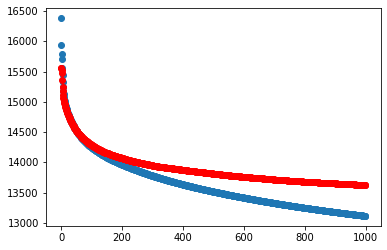

In [ ]:
plt.scatter(range(len(vae.history.history['loss'])), vae.history.history['loss'])
plt.scatter(range(len(vae.history.history['val_loss'])), vae.history.history['val_loss'], color='red')

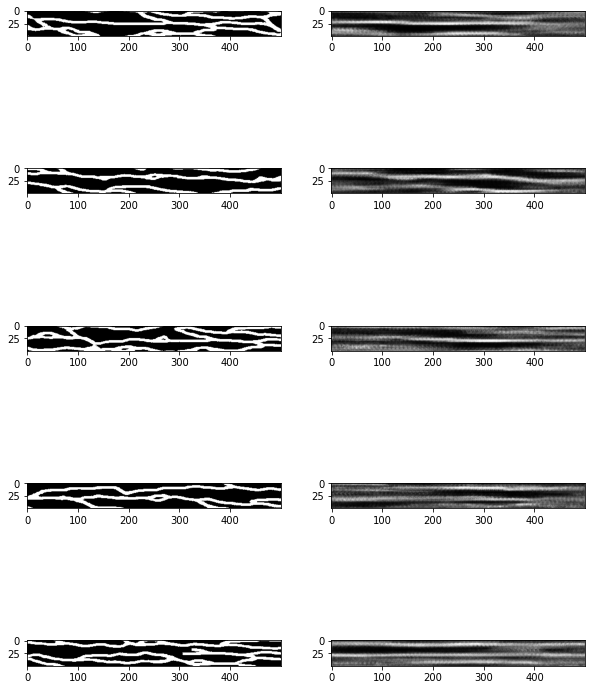

In [ ]:
# Show reconstructed images
show_original_reconstructed_images(vae, train_dataset)

Instantiate new model, load weights from last checkpoint and resume training

In [ ]:
# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, var_autoencoder = get_models(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS,), latent_dim=LATENT_DIM)

# Create new instance of VAE class
new_vae = VAE(encoder, decoder, var_autoencoder)

# Load weights from last checkpoint
checkpoint_dir = '.'
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)


./cp-cp1000.ckpt


In [ ]:
new_vae.load_weights(latest)
new_vae.compile(
    optimizer = tf.keras.optimizers.Adam(8e-4),
    loss = tf.keras.losses.BinaryCrossentropy()
)

IndexError: ignored

In [ ]:
new_vae.evaluate(augmented_train_dataset, verbose=1)

In [ ]:
# Create a callback that saves the model's weights every few epochs during training
checkpoint_path = './cp-cp{epoch:04d}.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    verbose = 1,
    save_weights_only = True,
    save_freq = math.ceil(num_examples*(1-TEST_SIZE)/BATCH_SIZE) * 100
)
# Create custom callback to display outputs (via helper function) at the end of each epoch of training
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        # Generate random vector as test input to the decoder
        random_vector_for_generation = tf.random.normal(shape=[8, LATENT_DIM])
        # Generate and save images
        display.clear_output(wait=True)
        if epoch % 100 == 0:
            generate_and_save_images(decoder, epoch, 
                                     math.ceil(num_examples/BATCH_SIZE), 
                                     random_vector_for_generation, new_vae)
        print('End of epoch {} - mean loss = {}'.format(epoch, logs[keys[0]]))

# Resume training using original dataset
new_vae.fit(x=augmented_train_dataset, epochs=800, 
            verbose=1, 
            validation_data=val_dataset, 
            callbacks=[cp_callback, CustomCallback()])

End of epoch 799 - mean loss = 12248.623046875


In [ ]:
plt.scatter(range(len(new_vae.history.history['loss'])), new_vae.history.history['loss'])
plt.scatter(range(len(new_vae.history.history['loss'])), new_vae.history.history['val_loss'], color='red')

Compare the original images with the reconstructed images from the trained model

In [ ]:
# Show reconstructed images
augmented_train_dataset, train_dataset, val_dataset, num_examples = get_datasets(test_size=TEST_SIZE)
show_original_reconstructed_images(new_vae, train_dataset)

In [ ]:
while True:
  pass

KeyboardInterrupt: ignored